In [ ]:
import numpy as np
from loguru import logger
from glob import glob
import os
import os.path as osp
import mmcv
from avcv.coco import *

import argparse

datasets = [
    ('/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/mobile_cigarette_train_081522_finetuning.json', 
        '/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/', 'mobile-train'), #mobile-train
    ('/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/mobile_cigarette_val_080422.json', 
        '/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/', 'mobile-val'), # mobile-val
    ('/data/DMS_Behavior_Detection/annotations/cvat_train_30_10_2022.json', '/data/DMS_Behavior_Detection/images/', 'cvat-food-train'),
    ('/data/public/coco/annotations/instances_train2017.json', '/data/public/coco/train2017/', 'coco-food-train'),
    ('/data/public/coco/annotations/instances_val2017.json', '/data/public/coco/val2017/', 'coco-food-val'),
]
new_root_dir = '/data/DMS_Behavior_Detection/annotations/'
new_img_dir = '/data/DMS_Behavior_Detection/images/'
mmcv.mkdir_or_exist(new_root_dir)

@imemoize
def load_annotations(ann):
    return mmcv.load(ann)

cats = []
for ann, _,_ in datasets:
    for cat in load_annotations(ann)['categories']:
        cats.append(cat['name'])

print(sorted(set(cats)))

['Food', 'airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'cigarette', 'clock', 'couch', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'food/drink', 'fork', 'frisbee', 'giraffe', 'hair drier', 'handbag', 'horse', 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'motorcycle', 'mouse', 'orange', 'oven', 'parking meter', 'person', 'phone', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'sink', 'skateboard', 'skis', 'snowboard', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'teddy bear', 'tennis racket', 'tie', 'toaster', 'toilet', 'toothbrush', 'traffic light', 'train', 'truck', 'tv', 'umbrella', 'vase', 'wine glass', 'zebra']


In [ ]:
category_old_to_new = {
    'cigarette':'cigarette',
    'food/drink':'food/drink',
    'phone':'phone',
    'cell phone': 'phone',
    'banana':'food/drink',
    'apple':'food/drink',
    'sandwich':'food/drink',
    'orange':'food/drink',
    'broccoli':'food/drink',
    'carrot':'food/drink',
    'hot dog':'food/drink',
    'pizza':'food/drink',
    'donut':'food/drink',
    'cake':'food/drink',
}

name2cat = {cat:i+1 for i,cat in enumerate(['phone', 'cigarette', 'food/drink'])}
categories = [{'id':i, 'name':name} for name, i in name2cat.items()]
categories

[{'id': 1, 'name': 'phone'},
 {'id': 2, 'name': 'cigarette'},
 {'id': 3, 'name': 'food/drink'}]

In [ ]:
datasets

[('/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/mobile_cigarette_train_081522_finetuning.json',
  '/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/',
  'mobile-train'),
 ('/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/mobile_cigarette_val_080422.json',
  '/data/DMS_Behavior_Detection/Mobile_Cigarret_DB/',
  'mobile-val'),
 ('/data/DMS_Behavior_Detection/annotations/cvat_train_30_10_2022.json',
  '/data/DMS_Behavior_Detection/images/',
  'cvat-food-train'),
 ('/data/public/coco/annotations/instances_train2017.json',
  '/data/public/coco/train2017/',
  'coco-food-train'),
 ('/data/public/coco/annotations/instances_val2017.json',
  '/data/public/coco/val2017/',
  'coco-food-val')]

In [ ]:
from avcv.all import *
out_dict = dict(
    images=[],
    annotations=[],
    categories=categories,
)
for json, img_dir, dname in datasets:
    cc = CocoDataset(load_annotations(json), img_dir)
    for img_id in cc.img_ids:
        img = cc.gt.imgs[img_id].copy()
        anns = cc.gt.imgToAnns[img_id]
        
        new_img_id = len(out_dict['images'])
        

        take = False
        for ann in anns:
            ann = ann.copy()
            ann['image_id'] = new_img_id
            old_cat_name = cc.gt.cats[ann['category_id']]['name']
            # Only wanted old class will be taken
            if old_cat_name in category_old_to_new:
                new_cat_name = category_old_to_new[old_cat_name]
                ann['category_id'] = name2cat[new_cat_name]
                ann['id'] = len(out_dict['annotations'])
                ann['area'] = ann['bbox'][2]*ann['bbox'][3]
                out_dict['annotations'].append(ann)
                take = True
        if take or not 'coco' in dname:
            new_img = dict()
            new_img['id'] = new_img_id
            new_img['dataset_name'] = dname
            abs_file_name = os.path.abspath(osp.join(cc.img_dir, img['file_name']))
            new_img['width'], new_img['height'] = Image.open(abs_file_name).size
            rel_path = os.path.relpath(abs_file_name, new_img_dir)
            new_img['file_name'] = rel_path

            
            out_dict['images'].append(new_img)   
print('Num of images:', len(out_dict['images']))

Num of images: 73705


In [ ]:
pd.DataFrame(out_dict['images']).groupby('dataset_name').size()

dataset_name
coco-food-train    20697
coco-food-val        902
cvat-food-train    41736
mobile-train        8732
mobile-val          1638
dtype: int64

In [ ]:
mmcv.dump(out_dict, '/data/DMS_Behavior_Detection/annotations/train_3class_phone_cigarette_food_with_coco.json')
newcc = CocoDataset('/data/DMS_Behavior_Detection/annotations/train_3class_phone_cigarette_food_with_coco.json')

2022-09-30 03:25:25.030 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=1143
2022-09-30 03:25:25.057 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=14163
2022-09-30 03:25:25.087 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=12817
2022-09-30 03:25:25.117 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=25800
2022-09-30 03:25:25.126 | INFO     | avcv.visualize:plot_images:30 - Grid size: (2, 2)


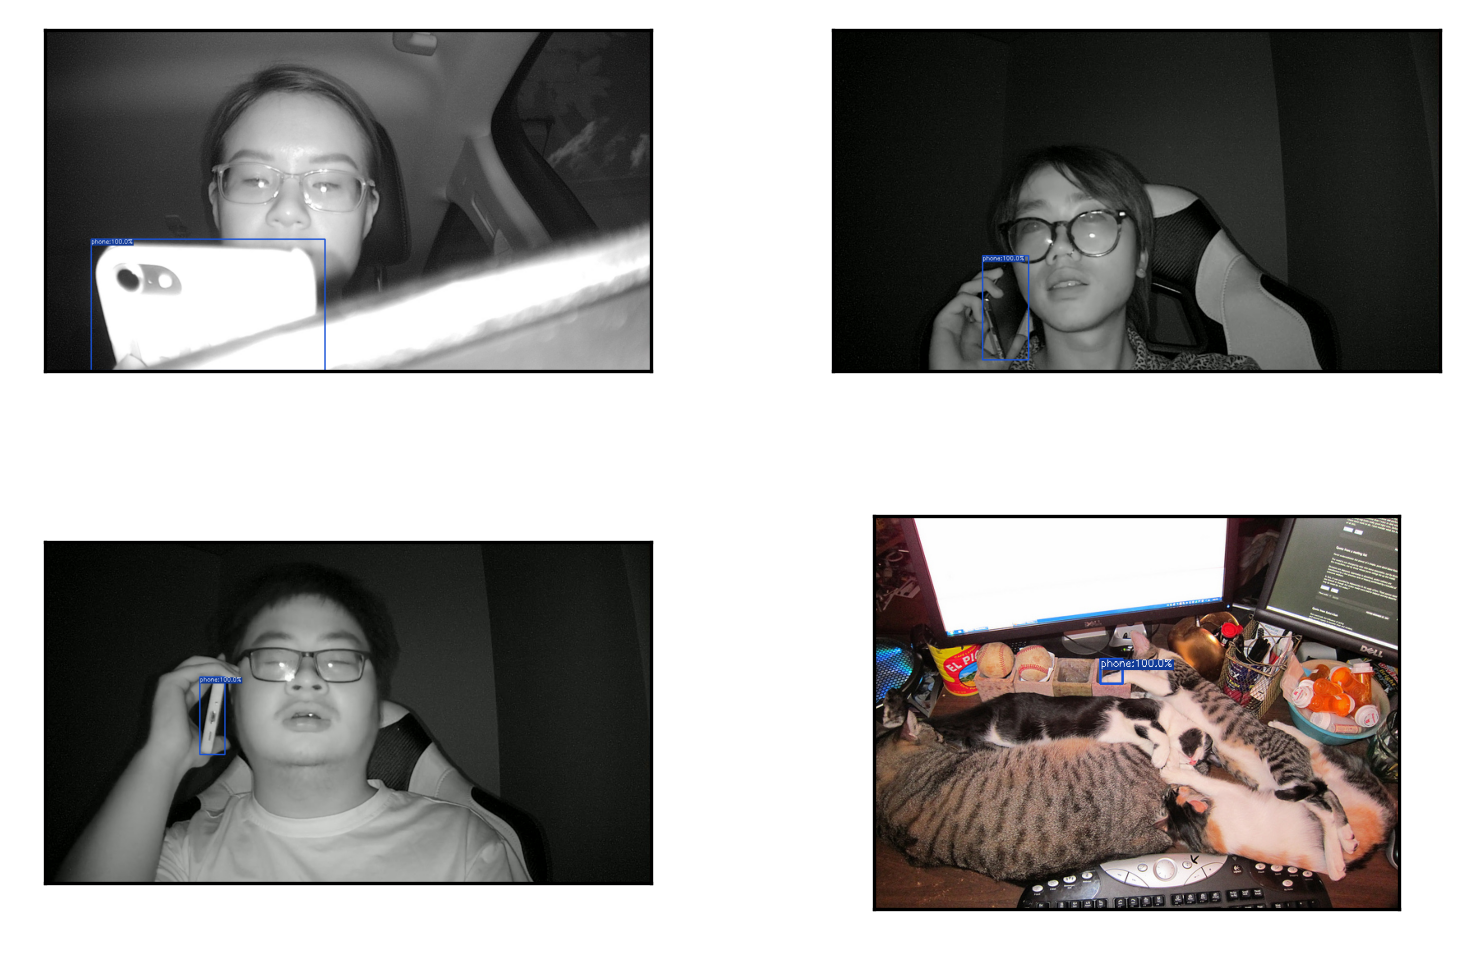

2022-09-30 03:25:26.037 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=29328
2022-09-30 03:25:26.053 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=32023
2022-09-30 03:25:26.068 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=6471
2022-09-30 03:25:26.087 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=25776
2022-09-30 03:25:26.101 | INFO     | avcv.visualize:plot_images:30 - Grid size: (2, 2)


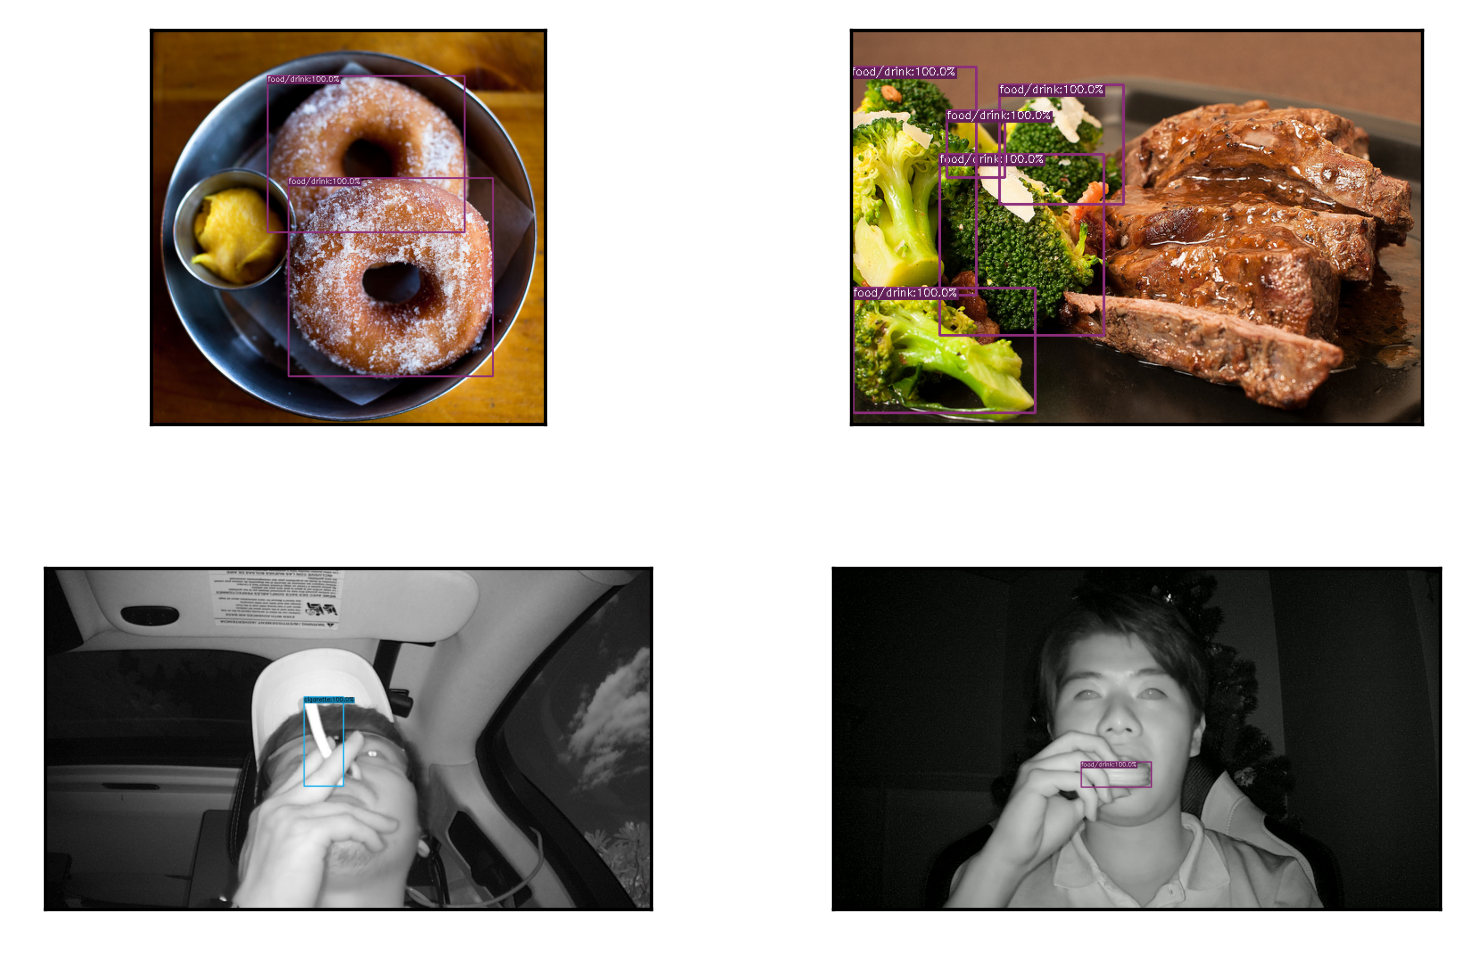

2022-09-30 03:25:26.945 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=18275
2022-09-30 03:25:26.975 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=1060
2022-09-30 03:25:27.000 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=19556
2022-09-30 03:25:27.029 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=20362
2022-09-30 03:25:27.053 | INFO     | avcv.visualize:plot_images:30 - Grid size: (2, 2)


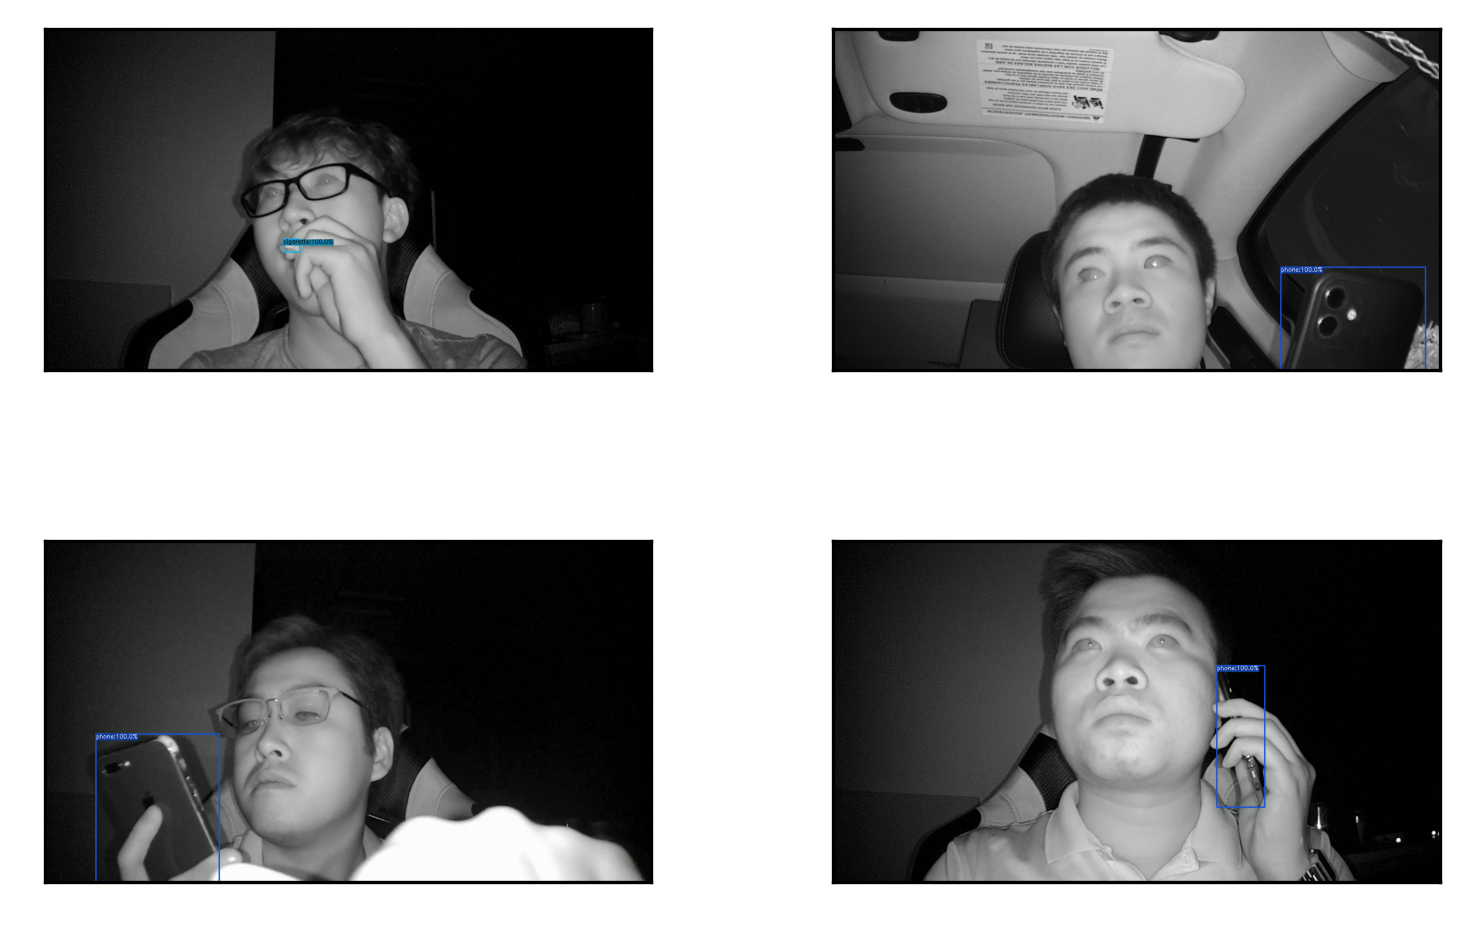

2022-09-30 03:25:27.977 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=3403
2022-09-30 03:25:28.000 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=30958
2022-09-30 03:25:28.014 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=33281
2022-09-30 03:25:28.030 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=43018
2022-09-30 03:25:28.038 | INFO     | avcv.visualize:plot_images:30 - Grid size: (2, 2)


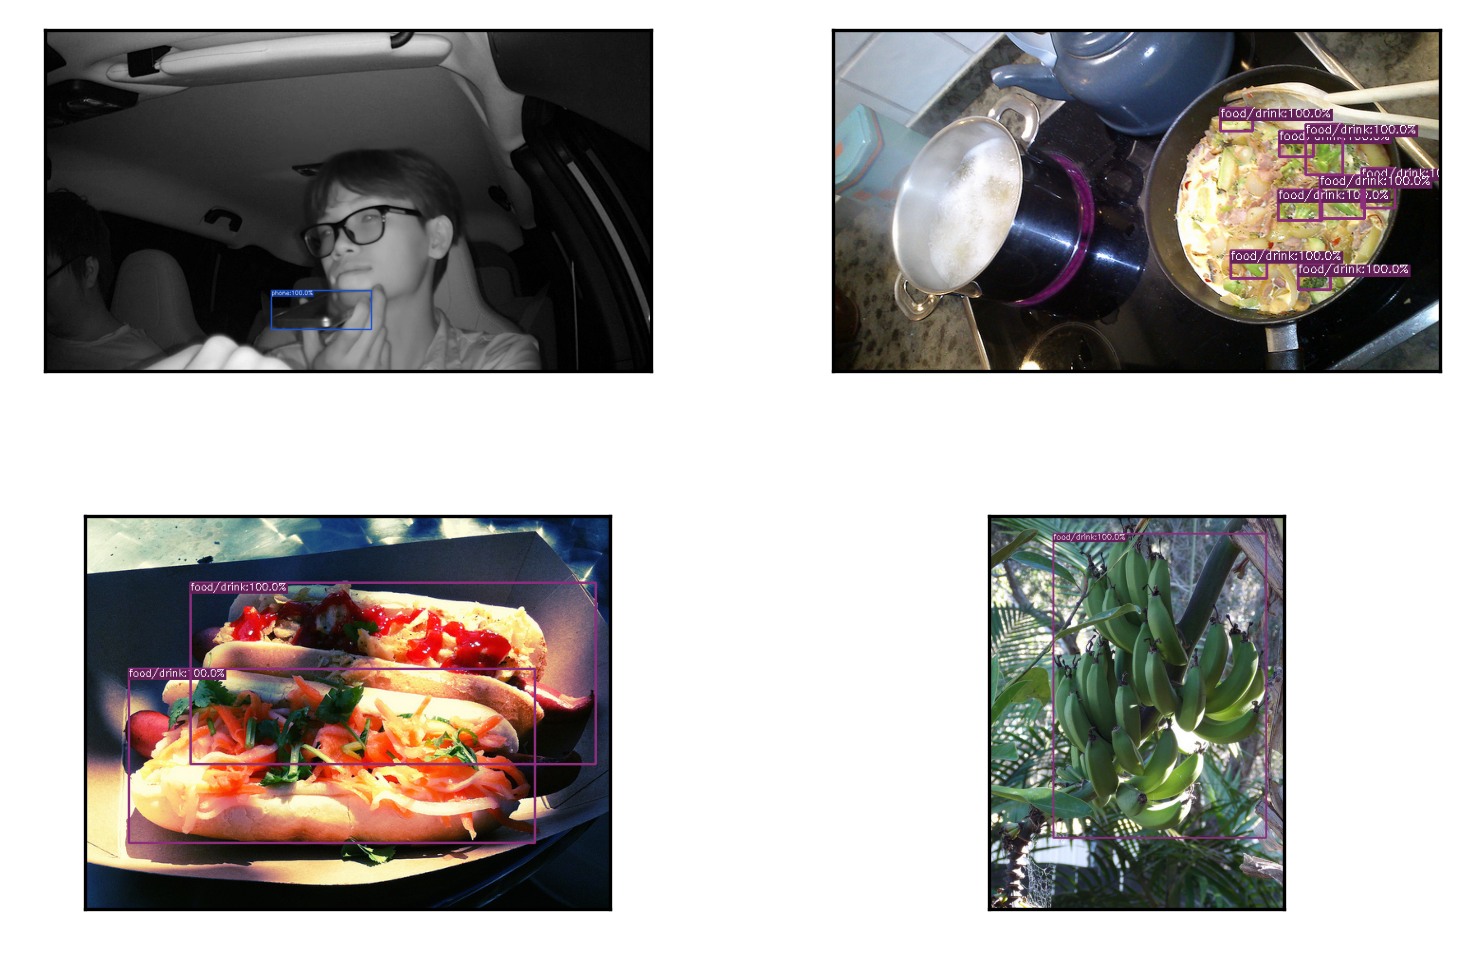

2022-09-30 03:25:28.791 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=21410
2022-09-30 03:25:28.821 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=42058
2022-09-30 03:25:28.832 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=2473
2022-09-30 03:25:28.861 | INFO     | avcv.coco:visualize:190 - Random visualize img_id=34492
2022-09-30 03:25:28.870 | INFO     | avcv.visualize:plot_images:30 - Grid size: (2, 2)


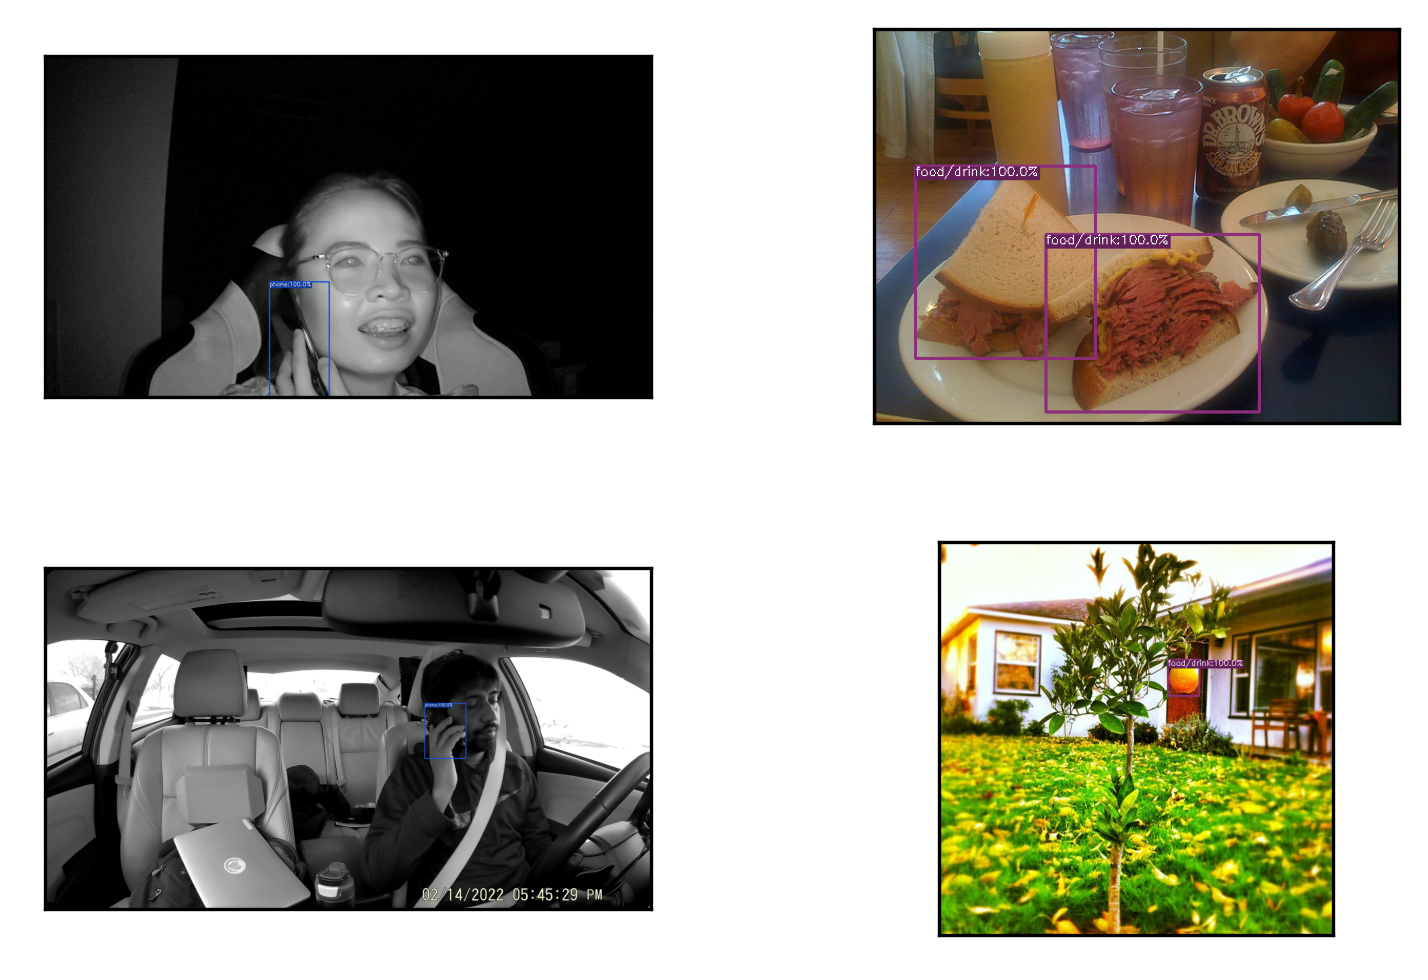

In [ ]:
vis_imgs = []
for i in range(20):
    vis_imgs.append(newcc.visualize(show=0)[...,::-1])
    if len(vis_imgs) == 4:
        plot_images(vis_imgs)
        vis_imgs = []